<a href="https://colab.research.google.com/github/JayantJharkhande3000/CS6910_Assignment_03_EtoH/blob/main/Question_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Question number 01


In [ ]:
import re
from tqdm import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential,Model,load_model
from keras.layers import Dense,LSTM,GRU,SimpleRNN,Input,Dropout,TimeDistributed,RepeatVector,dot,BatchNormalization,concatenate,multiply,Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

In [ ]:
train_data_path = "/content/drive/MyDrive/DATA/lexicons/hi.translit.sampled.train.tsv"
test_data_path = "/content/drive/MyDrive/DATA/lexicons/hi.translit.sampled.test.tsv"
validation_data_path = "/content/drive/MyDrive/DATA/lexicons/hi.translit.sampled.dev.tsv"

In [ ]:
# creating array for input (English) and Target for Output words
English_texts = []
hindi_texts = []
english_alphabets = set()
hindi_alphabets = set()
# Calling the training data 
with open(train_data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
# printing training data
print("\n Printing Raw Hindi and English DataSet \n")
for i in range(400,410):
  print(lines[i])


# Deleting the last line in training data
del lines[-1]

# separating the english and hindi words as input text and target text
for line in lines:
    hindi_text, english_text, _ = line.split("\t")
    english_text = "\t"+english_text + "\n"
    hindi_text = "\t"+hindi_text + "\n"

    English_texts.append(english_text)
    hindi_texts.append(hindi_text)

    for character in english_text:
        if character not in english_alphabets:
            english_alphabets.add(character)
    for character in hindi_text:
        if character not in hindi_alphabets:
            hindi_alphabets.add(character)

english_alphabets.add(" ")
hindi_alphabets.add(" ")

# total number of sample 
print("\n")
print("Total number of English input samples in training :", len(English_texts))
print("Total number of  Hindi output samples in training :", len(hindi_texts))


# characters in hindi and english vocabulary
english_alphabets = sorted(list(english_alphabets))
print("\n english_alphabets English  \n")
print(english_alphabets)
hindi_alphabets = sorted(list(hindi_alphabets))
print("\n hindi_alphabets Hindi  \n")
print(hindi_alphabets)

english_tokens = len(english_alphabets)
print("\nTotal number of characters in English  dictionary :",english_tokens)

hindi_tokens = len(hindi_alphabets)
print("\nTotal number of characters in Hindi dictionary :", hindi_tokens)

english_max_length = max([len(txt) for txt in English_texts])
print("Max sequence length in the english :", english_max_length)

hindi_max_length = max([len(txt) for txt in hindi_texts])
print("Max sequence length in the hindi :", hindi_max_length)

# converting character of hindi and english dictionary to numbers

eng_alp_to_num = dict([(char, i) for i, char in enumerate(english_alphabets)])
print("\n english alphabets converted to numeric value \n", eng_alp_to_num)
hin_alp_to_num = dict([(char, i) for i, char in enumerate(hindi_alphabets)])
print("\n hindi alphabets converted to numeric value \n", hin_alp_to_num)


 Printing Raw Hindi and English DataSet 

अचार	achaar	2
अचार	achar	2
अचिन	achin	3
अचूक	achook	1
अचूक	achuk	2
अचेत	achet	2
अचेत	ahet	1
अचेतन	achetan	3
अच्छा	accha	1
अच्छा	achcha	2


Total number of English input samples in training : 44204
Total number of  Hindi output samples in training : 44204

 english_alphabets English  

['\t', '\n', ' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

 hindi_alphabets Hindi  

['\t', '\n', ' ', 'ँ', 'ं', 'ः', 'अ', 'आ', 'इ', 'ई', 'उ', 'ऊ', 'ऋ', 'ए', 'ऐ', 'ऑ', 'ओ', 'औ', 'क', 'ख', 'ग', 'घ', 'ङ', 'च', 'छ', 'ज', 'झ', 'ञ', 'ट', 'ठ', 'ड', 'ढ', 'ण', 'त', 'थ', 'द', 'ध', 'न', 'प', 'फ', 'ब', 'भ', 'म', 'य', 'र', 'ल', 'व', 'श', 'ष', 'स', 'ह', '़', 'ा', 'ि', 'ी', 'ु', 'ू', 'ृ', 'ॅ', 'े', 'ै', 'ॉ', 'ो', 'ौ', '्', 'ॐ']

Total number of characters in English  dictionary : 29

Total number of characters in Hindi dictionary : 66
Max sequence length in the english : 22
Max sequence l

In [ ]:
# English_To_Hindi
class English_To_Hindi:
    # Initializing the parameters 
    def __init__(self,cell_type,embedding_size,hidden_layer_size,encoder_layers_size,decoder_layers_size,dropouts,epochs,batch_size,
                 english_alphabets,hindi_alphabets,english_max_length,hindi_max_length,english_tokens,hindi_tokens,
                 eng_alp_to_num,hin_alp_to_num,activation,optimizer,train_data_path,test_data_path,validation_data_path ):
        self.cell_type = cell_type
        self.embedding_size = embedding_size
        self.hidden_layer_size = hidden_layer_size
        self.encoder_layers_size = encoder_layers_size
        self.decoder_layers_size = decoder_layers_size
        self.dropouts=dropouts
        self.epochs=epochs
        self.batch_size=batch_size
        self.english_alphabets = english_alphabets
        self.hindi_alphabets = hindi_alphabets 
        self.english_max_length = english_max_length
        self.hindi_max_length = hindi_max_length
        self.english_tokens =  english_tokens
        self.hindi_tokens =  hindi_tokens
        self.eng_alp_to_num =  eng_alp_to_num
        self.hin_alp_to_num =  hin_alp_to_num
        self.activation =  activation
        self.optimizer =  optimizer
        self.train_data_path =  train_data_path
        self.test_data_path =  test_data_path
        self.validation_data_path = validation_data_path
        
    # Converting english and hindi text to numeric array
    def text_to_array(self,path):
        d = pd.read_csv(path,sep="\t",header=None,error_bad_lines=False)
        d = d.dropna()

        decoder_target_data = np.zeros((d.shape[0],self.hindi_max_length,self.hindi_tokens), dtype="float32")

        for i,target_text in enumerate(d[0]):
            target_text = '\t'+target_text+'\n'
            for t, char in enumerate(target_text):
                if t > 0:
                    decoder_target_data[i, t - 1, self.hin_alp_to_num[char]] = 1.0
            decoder_target_data[i, t:, self.hin_alp_to_num["\n"]] = 1.0

        return ([[self.eng_alp_to_num[letter] for letter in list('\t'+word+'\n')] for word in d[1]]),\
                ([[self.hin_alp_to_num[letter] for letter in list('\t'+word+'\n')] for word in d[0]]),decoder_target_data
    
    # Encoder Decoder function for train, test, validation set
    def encoder_decoder(self):
        # Dict for index to char
        self.inv_input_token_index = dict({(value,key) for key,value in self.eng_alp_to_num.items()})
        self.inv_target_token_index = dict({(value,key) for key,value in self.hin_alp_to_num.items()})

        train_eng_input_encoder,train_eng_out_decoder,self.train_hin_target_decoder = self.text_to_array(self.train_data_path)
        vali_eng_input_encoder,vali_eng_out_decoder,self.vali_hin_target_decoder = self.text_to_array(self.validation_data_path)
        test_eng_input_encoder,test_eng_out_decoder,self.test_hin_target_decoder = self.text_to_array(self.test_data_path)

        self.train_eng_input_encoder = sequence.pad_sequences(train_eng_input_encoder,maxlen=self.english_max_length,padding="post")
        self.train_eng_out_decoder = sequence.pad_sequences(train_eng_out_decoder,maxlen=self.hindi_max_length,padding="post")
        self.vali_eng_input_encoder = sequence.pad_sequences(vali_eng_input_encoder,maxlen=self.english_max_length,padding="post")
        self.vali_eng_out_decoder = sequence.pad_sequences(vali_eng_out_decoder,maxlen=self.hindi_max_length,padding="post")
        self.test_eng_input_encoder = sequence.pad_sequences(test_eng_input_encoder,maxlen=self.english_max_length,padding="post")
        self.test_eng_out_decoder = sequence.pad_sequences(test_eng_out_decoder,maxlen=self.hindi_max_length,padding="post")
        


    def build_model(self):
        # Encoder box 
        encoder_inputs = Input(shape=(None,))
        x = Embedding(self.english_tokens,self.embedding_size,input_length=self.english_max_length)(encoder_inputs)
        for _ in range(self.encoder_layers_size):
            # if cell type = LSTM
            if self.cell_type == "lstm":
                x,state_h,state_c = LSTM(self.hidden_layer_size,return_state=True,return_sequences=True,dropout=self.dropouts)(x)
                encoder_states = [state_h,state_c]
            # if cell type = RNN
            elif self.cell_type == "rnn":
                x,state_c = SimpleRNN(self.hidden_layer_size,return_state=True,return_sequences=True,dropout=self.dropouts)(x)
                encoder_states = [state_c]
            # if cell type = GRU
            elif self.cell_type == "gru":
                x,state_c = GRU(self.hidden_layer_size,return_state=True,return_sequences=True,dropout=self.dropouts)(x)
                encoder_states = [state_c]
                        
        # Decoder box 
        decoder_inputs = Input(shape=(None,))
        decoder_embb = Embedding(self.hindi_tokens,self.embedding_size,input_length=self.hindi_max_length)(decoder_inputs)
        # if cell type = LSTM
        if self.cell_type == "lstm":
            decoder_lstm,state_h,state_c = LSTM(self.hidden_layer_size, return_sequences=True,
                                                return_state=True,dropout=self.dropouts)(decoder_embb,initial_state=encoder_states)
        # if cell type = RNN
        elif self.cell_type == "rnn":
            decoder_lstm,state_h = SimpleRNN(self.hidden_layer_size, return_sequences=True,
                                             return_state=True,dropout=self.dropouts)(decoder_embb,initial_state=encoder_states)
        # if cell type = GRU
        elif self.cell_type == "gru":
            decoder_lstm,state_h = GRU(self.hidden_layer_size, return_sequences=True,
                                       return_state=True,dropout=self.dropouts)(decoder_embb,initial_state=encoder_states)

        for i in range(self.decoder_layers_size-1):
            # if cell type = LSTM
            if self.cell_type == "lstm":
                decoder_lstm,state_h,state_c = LSTM(self.hidden_layer_size, return_sequences=True,return_state=True,dropout=self.dropouts)(decoder_lstm)
            # if cell type = RNN
            elif self.cell_type == "rnn":
                decoder_lstm,state_h = SimpleRNN(self.hidden_layer_size, return_sequences=True,return_state=True,dropout=self.dropouts)(decoder_lstm)
            # if cell type = GRU
            elif self.cell_type == "gru":
                decoder_lstm,state_h = GRU(self.hidden_layer_size, return_sequences=True,return_state=True,dropout=self.dropouts)(decoder_lstm)
        

        decoder_outputs = TimeDistributed(Dense(self.hindi_tokens, activation= self.activation))(decoder_lstm)

        model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

        return model

    def predictions(self,model):
        count = 0
        for i in tqdm(range(self.test_eng_input_encoder.shape[0])):
            pred = model([np.expand_dims(self.test_eng_input_encoder[i],0),np.expand_dims(self.test_eng_out_decoder[i],0)])
            actual_out = re.sub('\t|\n','',''.join([self.inv_target_token_index[self.test_eng_out_decoder[i][j]] for j in range(self.hindi_max_length)]))
            predicted_out = re.sub('\t|\n','',''.join(self.inv_target_token_index[np.argmax(pred[0][j])] for j in range(self.hindi_max_length)))
            if (actual_out==predicted_out):
                count+=1
        return count/self.test_eng_input_encoder.shape[0]

    def run(self,model):
        # Compile & run training
        model.compile(optimizer= self.optimizer, loss='categorical_crossentropy', metrics=["accuracy"])

        model.fit([self.train_eng_input_encoder,self.train_eng_out_decoder], self.train_hin_target_decoder,
                self.batch_size,self.epochs,validation_data=([self.vali_eng_input_encoder,self.vali_eng_out_decoder], self.vali_hin_target_decoder))

In [ ]:
cell_type = "rnn" # Type of the recurring unit
embedding_size = 27   # encoder decoder embedding size
hidden_layer_size = 128  # # Latent dimensionality in encoding
encoder_layers_size = 1  # number of hidden layers in encoder
decoder_layers_size = 1  # number of hidden layers in decoder
dropouts= 0.0   #Dropout
epochs= 1 # Number of epochs to train for.
batch_size = 32  # Batch size for training.
activation = "softmax" #activation
optimizer = "Adam"  #optimizer



In [ ]:
English_To_Hindi_translation = English_To_Hindi(cell_type,embedding_size,hidden_layer_size,encoder_layers_size,decoder_layers_size,
                                                dropouts,epochs,batch_size,english_alphabets,hindi_alphabets,english_max_length,
                                                hindi_max_length,english_tokens,hindi_tokens,eng_alp_to_num,hin_alp_to_num,
                                                activation,optimizer,train_data_path,test_data_path,validation_data_path )
English_To_Hindi_translation.encoder_decoder()
English_To_Hindi_translation_Model = English_To_Hindi_translation.build_model()
English_To_Hindi_translation.run(English_To_Hindi_translation_Model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.




1382/1382 [==============================] - 24s 16ms/step - loss: 1.0154 - accuracy: 0.7343 - val_loss: 0.9074 - val_accuracy: 0.7534


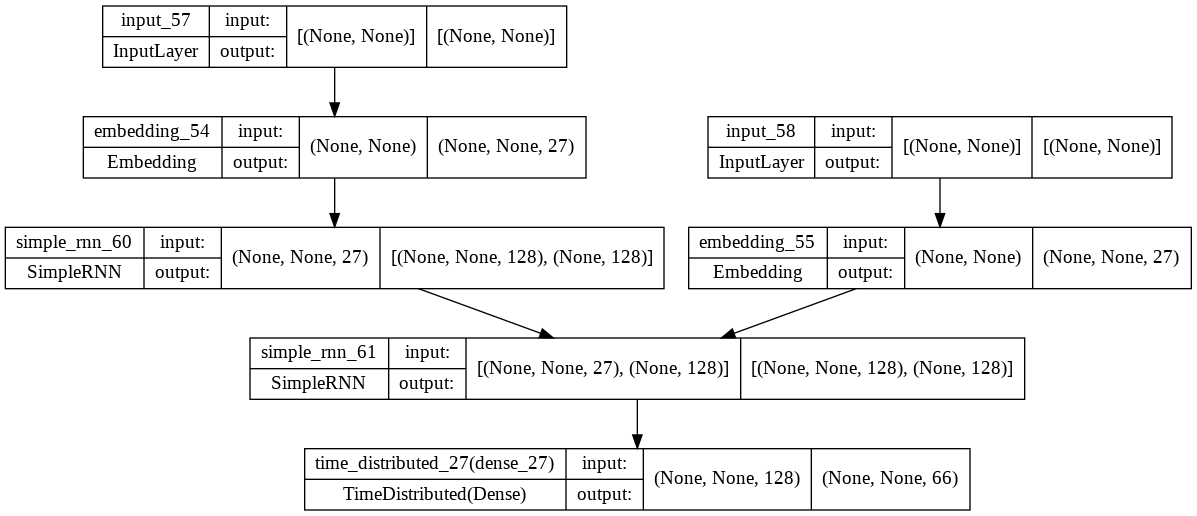

In [ ]:
tf.keras.utils.plot_model(English_To_Hindi_translation_Model,to_file='model.png',show_shapes=True)